In [1]:
%matplotlib inline
import numpy as np
from pandas import DataFrame as df
import UserResults as ur
from Classifiers import TransparentRidge
from scipy.sparse import diags
import matplotlib.pyplot as plt
import UserMatrix as um
import pickle

In [2]:
# Loading user ratings and movie list
ratings = np.genfromtxt('postprocessed-data/user_ratings', delimiter=',', dtype=int)
movies = np.genfromtxt('postprocessed-data/movie_list', delimiter='|', dtype=str)

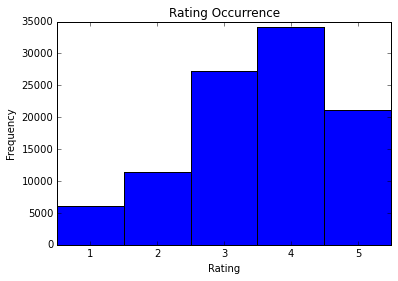

In [3]:
# Rating distribution
x = ratings.flat
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title("Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

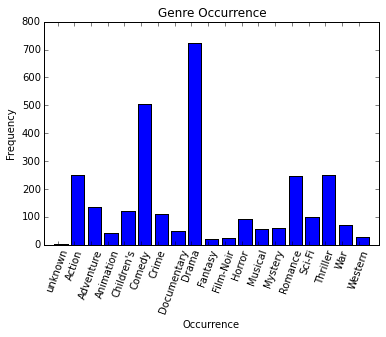

In [4]:
# Genre Distribution
genres = np.genfromtxt('ml-100k/u.item', delimiter='|', usecols=range(5, 24))
genre_names = np.genfromtxt('ml-100k/u.genre', delimiter='|', dtype=str, usecols=0)
x = np.sum(genres, axis=0)
his = np.histogram(x, bins = range(0,20))
fig, ax = plt.subplots()
offset = -.2
plt.bar(his[1][1:],x,align='center')
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels((list(genre_names)))
locs, labels = plt.xticks()
plt.setp(labels, rotation=70)
plt.title("Genre Occurrence")
plt.xlabel("Occurrence")
plt.ylabel("Frequency")
plt.show()

In [5]:
# Most Frequent Keywords
keyword_matrix = np.genfromtxt('postprocessed-data/keywords_matrix', delimiter=',', dtype=int)
keywords = np.genfromtxt('postprocessed-data/keyword_list', dtype=str)
frequency = np.sum(keyword_matrix, axis=0)
indices = np.argsort(frequency)[::-1]
keyword_df = df((np.column_stack((keywords[indices], frequency[indices]))), columns = ("Keyword", "Frequency"))
print keyword_df.head(20)

                         Keyword Frequency
0               independent-film       480
1                         murder       414
2                          death       320
3      husband-wife-relationship       300
4                 based-on-novel       296
5                           love       292
6                       violence       287
7                      cult-film       276
8      title-spoken-by-character       274
9                     friendship       270
10                         blood       268
11       father-son-relationship       261
12          family-relationships       256
13                 female-nudity       254
14       character-name-in-title       253
15                           sex       243
16                        police       236
17             cigarette-smoking       235
18       mother-son-relationship       223
19  father-daughter-relationship       220


In [6]:
# Most Frequent Actors
actor_matrix = np.genfromtxt('postprocessed-data/actor_and_actress_matrix', delimiter=',')
actors = open("postprocessed-data/pop_actor_set")
actors = np.array(actors.read().splitlines())
frequency = np.sum(actor_matrix, axis=0)
indices = np.argsort(frequency)[::-1]
keyword_df = df((np.column_stack((actors[indices], frequency[indices]))), columns = ("Actor", "Frequency"))
keyword_df = keyword_df.convert_objects(convert_numeric=True)
print keyword_df.head(20)

                          Actor  Frequency
0                 Welker, Frank         33
1                   Banks, Lena         22
2                 Flowers, Bess         20
3              Harris, Sam (II)         19
4                Buscemi, Steve         19
5                   Hedaya, Dan         18
6            Jackson, Samuel L.         18
7           Rosales Jr., Thomas         18
8               De Niro, Robert         17
9                 Moratz, Ralph         16
10             Goldberg, Whoopi         16
11           von Bargen, Daniel         16
12  Lucas, Marshall Dancing Elk         16
13             Berkeley, Xander         15
14                DeVito, Danny         15
15            Howard, Rance (I)         15
16                Tovey, Arthur         15
17               Keitel, Harvey         15
18            Jones, James Earl         15
19               Walter, Tracey         15


In [7]:
# Loading user matrix
user_id = 945
user_matrix = um.get_user_matrix(user_id)
user_ratings = ratings[user_id-1]

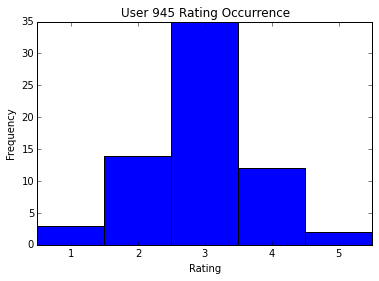

In [8]:
# User rating distribution
x = user_ratings
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title("User " + str(user_id) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [33]:
# Creating model
clf =TransparentRidge(alpha=15)
user_cols = user_matrix.shape[1]
data = user_matrix[:, 1:(user_cols-1)]
target = user_matrix[:, (user_cols-1)]
clf.fit(data,target)
weights = clf.coef_
neg_evi, pos_evi = clf.predict_evidences(data)
bias = clf.get_bias()
y_pred = clf.predict(data)
indices = np.argsort(y_pred)
coef_diags = diags(clf.coef_, 0)
dm = data * coef_diags

In [34]:
# The Highest Rating
j = indices[-1]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)

print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Shawshank Redemption, The (1994)
User Rating:  5
Average Rating:  4.44210526316
Number of Ratings:  285


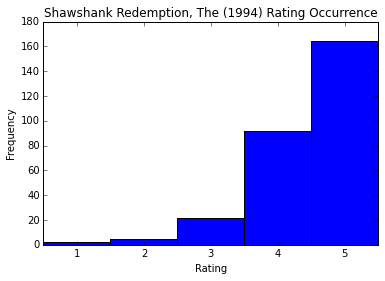

In [35]:
# Movie Rating Distribution
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [36]:
# Evidence
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  4.55795321792
Bias and evidences: 3.19221026975 -0.403587835319 1.76933078349
Positive Features
             Feature  Weights
0     Average Rating   0.3195
1             corpse   0.0986
2              anger   0.0977
3  subjective-camera   0.0887
4              Drama   0.0742
5          cult-film   0.0733
6  Number of Ratings   0.0719
7                car   0.0694
8         corruption   0.0597
9            suicide   0.0475
Negative Features
            Feature  Weights
0           revenge  -0.0539
1            police  -0.0389
2      photographer  -0.0349
3             blood  -0.0330
4   surprise-ending  -0.0324
5            prison  -0.0322
6            escape  -0.0293
7           rooftop  -0.0287
8  man-with-glasses  -0.0234
9          revolver  -0.0173


In [37]:
# The Lowest Rating
j = indices[0]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Speed 2: Cruise Control (1997)
User Rating:  1
Average Rating:  2.14285714286
Number of Ratings:  14


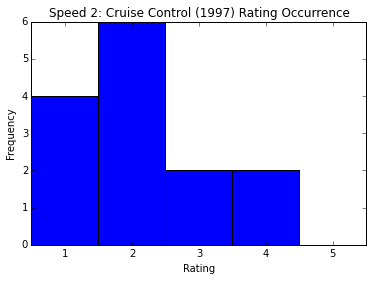

In [38]:
# Movie Rating Distribution
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [39]:
# Evidence
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  1.32239757039
Bias and evidences: 3.19221026975 -2.1555547351 0.285742035739
Positive Features
                  Feature  Weights
0               cult-film   0.0733
1                     dog   0.0284
2            one-man-army   0.0240
3              flashlight   0.0239
4                     bar   0.0236
5  los-angeles-california   0.0209
6                violence   0.0205
7            martial-arts   0.0192
8                gunfight   0.0150
9               tough-guy   0.0128
Negative Features
             Feature  Weights
0     Average Rating  -0.3199
1          explosion  -0.1269
2  Number of Ratings  -0.1085
3         restaurant  -0.0931
4          nightclub  -0.0914
5   good-versus-evil  -0.0875
6               bomb  -0.0703
7             Action  -0.0660
8             pistol  -0.0621
9           elevator  -0.0602


In [40]:
# The case that has the most negative evidence, regardless of positive evidence
j = np.argsort(neg_evi)[0]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Speed 2: Cruise Control (1997)
User Rating:  1
Average Rating:  2.14285714286
Number of Ratings:  14


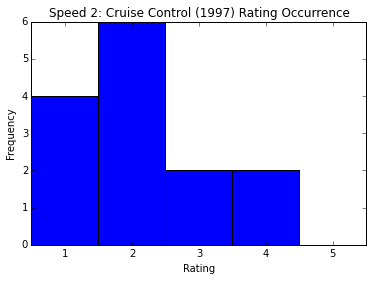

In [41]:
# Movie Rating Distribution
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [42]:
# Evidence
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  1.32239757039
Bias and evidences: 3.19221026975 -2.1555547351 0.285742035739
Positive Features
                  Feature  Weights
0               cult-film   0.0733
1                     dog   0.0284
2            one-man-army   0.0240
3              flashlight   0.0239
4                     bar   0.0236
5  los-angeles-california   0.0209
6                violence   0.0205
7            martial-arts   0.0192
8                gunfight   0.0150
9               tough-guy   0.0128
Negative Features
             Feature  Weights
0     Average Rating  -0.3199
1          explosion  -0.1269
2  Number of Ratings  -0.1085
3         restaurant  -0.0931
4          nightclub  -0.0914
5   good-versus-evil  -0.0875
6               bomb  -0.0703
7             Action  -0.0660
8             pistol  -0.0621
9           elevator  -0.0602


In [14]:
# The case that has the most positive evidence, regardless of negative evidence
j = np.argsort(pos_evi)[-1]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

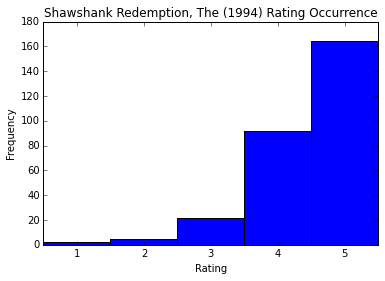

In [44]:
# Movie Rating Distribution
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [45]:
# Evidence
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  4.55795321792
Bias and evidences: 3.19221026975 -0.403587835319 1.76933078349
Positive Features
             Feature  Weights
0     Average Rating   0.3195
1             corpse   0.0986
2              anger   0.0977
3  subjective-camera   0.0887
4              Drama   0.0742
5          cult-film   0.0733
6  Number of Ratings   0.0719
7                car   0.0694
8         corruption   0.0597
9            suicide   0.0475
Negative Features
            Feature  Weights
0           revenge  -0.0539
1            police  -0.0389
2      photographer  -0.0349
3             blood  -0.0330
4   surprise-ending  -0.0324
5            prison  -0.0322
6            escape  -0.0293
7           rooftop  -0.0287
8  man-with-glasses  -0.0234
9          revolver  -0.0173


In [46]:
# Most conflicted
conflict = np.min([abs(neg_evi), pos_evi], axis=0)
indices = np.argsort(conflict)
j=indices[-1]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Titanic (1997)
User Rating:  3
Average Rating:  3.16049382716
Number of Ratings:  81


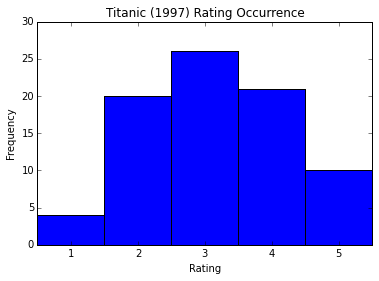

In [47]:
# Movie Rating Distribution
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [48]:
# Evidence
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  2.954211679
Bias and evidences: 3.19221026975 -1.54069749263 1.30269890189
Positive Features
               Feature  Weights
0      unrequited-love   0.0992
1               corpse   0.0986
2    subjective-camera   0.0887
3                Drama   0.0742
4            cult-film   0.0733
5                  car   0.0694
6  falling-from-height   0.0572
7              suicide   0.0475
8               church   0.0462
9                Crime   0.0446
Negative Features
                        Feature  Weights
0                     explosion  -0.1269
1                      jealousy  -0.0940
2                    restaurant  -0.0931
3  mother-daughter-relationship  -0.0727
4             Number of Ratings  -0.0639
5                        pistol  -0.0621
6                      elevator  -0.0602
7                       revenge  -0.0539
8                     handcuffs  -0.0523
9                Average Rating  -0.0502


In [49]:
# Least amount of info
information = np.max([abs(neg_evi), pos_evi], axis=0)
indices = np.argsort(information)
j=indices[0]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Return of the Pink Panther, The (1974)
User Rating:  3
Average Rating:  3.54838709677
Number of Ratings:  93


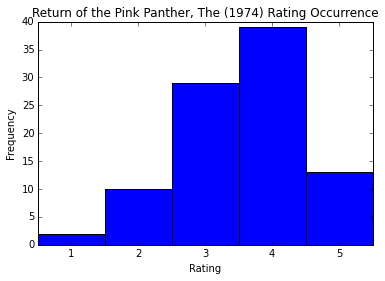

In [50]:
# Movie Rating Distribution
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [52]:
# Evidence
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  3.17226003094
Bias and evidences: 3.19221026975 -0.0831241817808 0.0631739429755
Positive Features
          Feature  Weights
0  Average Rating   0.0632
Negative Features
             Feature  Weights
0  Number of Ratings  -0.0559
1             Comedy  -0.0272
